In [5]:
import os
# Making sure it downloads models on my D drive, as no space in defualt file location

from tqdm.notebook import tqdm
import pandas as pd
import os
import csv
import sys
import numpy as np
import time
import random
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import textwrap
import torch
import json

from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_scheduler, EarlyStoppingCallback
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from pathlib import Path

from transformers.models.roberta.modeling_roberta import (
    RobertaModel,
    RobertaEncoder,
    RobertaLayer,
    RobertaEmbeddings,
    RobertaConfig,
)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/final

/content/drive/MyDrive/final


In [4]:
!pip install transformers datasets peft evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using Device: {device}')

Using Device: cuda


In [7]:
# Define model directories
BASE_MODEL_DIR = "./base_model"
LORA_MODEL_DIR = "./lora_model"
ADAPTER_MODEL_DIR = "./adapter_model"

In [11]:
# base train output dir
TRAIN_OUTPUT_DIR = "./train_output"
def output_file_name(model_name):
    return f'{TRAIN_OUTPUT_DIR}/training_results_{model_name}.json'
# Base directory names
from datetime import datetime

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_results_dir = f"./results/base" #_{timestamp}"
lora_results_dir = f"./results/lora" #_{timestamp}"
adapter_results_dir = f"./results/adapter" #_{timestamp}"

# Ensure directories exist
Path(base_results_dir).mkdir(parents=True, exist_ok=True)
Path(lora_results_dir).mkdir(parents=True, exist_ok=True)
Path(adapter_results_dir).mkdir(parents=True, exist_ok=True)

In [12]:
import pandas as pd
from transformers import TrainerCallback
import os

class CSVLoggerCallback(TrainerCallback):
    def __init__(self, log_file="./logs/training_log.csv"):
        self.log_file = log_file
        if not os.path.exists(log_file):
            # Initialize the CSV with headers if it doesn't exist
            with open(log_file, "w") as f:
                f.write("step,loss,lr,gradient_norm\n")

    def on_log(self, args, state, control, logs=None, model=None, **kwargs):
        if logs is not None and model is not None:
            step = state.global_step
            loss = logs.get("loss", None)
            lr = logs.get("learning_rate", None)

            # Calculate the gradient norm
            gradient_norm = logs.get("grad_norm", None)

            # Append to CSV
            if loss is not None:
                with open(self.log_file, "a") as f:
                    f.write(f"{step},{loss},{lr},{gradient_norm}\n")

In [43]:
def print_trainable_params(model, stage_name="Model"):
    print(f"\nTrainable Parameters in {stage_name}:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"%\\age of trainable params: {(trainable_params/total_params) * 100}")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(f"  - {name}: {param.numel()} params")

In [14]:
#Number of epochs for all models
num_epochs = 5
# Base TrainingArguments configuration
base_args = {
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": num_epochs,
    "weight_decay": 0.01,
    "logging_steps": 100,
    "load_best_model_at_end": True,
    "fp16": True,
    "report_to": "none",
    "metric_for_best_model": "eval_loss",
    "greater_is_better": False,
}

In [15]:
# To create dynamic result directory
def create_training_args(output_dir, lr):
    return TrainingArguments(
        output_dir=output_dir,
        logging_dir=f"{output_dir}/logs",
        learning_rate = lr,
        **base_args,
    )

In [16]:
# Load Llama 1B and tokenizer
model_name = "meta-llama/Llama-3.2-1B"  # Using LLama 1B as base model

# Couldn't train Llama because of lower mem GPUs so shifting to roberta
model_name = "FacebookAI/roberta-large"

# Step 1: Load or initialize tokenizer
if os.path.exists(BASE_MODEL_DIR):
    print("\nTokenizer already exists. Loading from base model directory...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_DIR)
else:
    print("\nInitializing tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Ensure tokenizer has a padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as PAD token


Tokenizer already exists. Loading from base model directory...


In [65]:
# Loading Dataset
ds = load_dataset("stanfordnlp/imdb")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

# Tokenize datasets
tokenized_datasets = ds.map(preprocess_function, batched=True)

# Prepare train and test datasets
train_dataset = tokenized_datasets["train"].shuffle(seed=42)  # Use full training dataset
test_dataset = tokenized_datasets["test"].shuffle(seed=42)    # Use full testing dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [18]:
# Untokenized example
untokenized_text = ds["train"][0]["text"]
print("Untokenized:", untokenized_text)
print("Label:",  ds["train"][0]["label"])
# Tokenized example
tokenized_example = preprocess_function({"text": [untokenized_text]})
print("Tokenized:", tokenized_example)


Untokenized: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far

In [29]:
# Function to evaluate models
def evaluate_model_summary(model, training_args, name):
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )
    print(f"\nEvaluating {name} Model...")
    results = trainer.evaluate()
    print(f"{name} Model Results:", results)
    return results

In [20]:
# Step 2: Train or load the base model
base_training_args = create_training_args(output_dir=base_results_dir, lr=2e-5)

if os.path.exists(BASE_MODEL_DIR):
    print("\nBase model already exists. Loading base model...")
    base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_DIR)
else:
    print("\nTraining Base Model...")
    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    base_model.config.pad_token_id = base_model.config.eos_token_id
    trainer_base = Trainer(
        model=base_model,
        args=base_training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), CSVLoggerCallback("./logs/training_log_base.csv")],
    )
    print_trainable_params(base_model, stage_name="Base Model")
    base_model.to(device)
    start_time = time.time()
    train_output = trainer_base.train()
    print(f"Base Model training time: {time.time() - start_time}s")
    base_model.save_pretrained(BASE_MODEL_DIR)
    tokenizer.save_pretrained(BASE_MODEL_DIR)
    output_file = output_file_name('base')
    with open(output_file, 'w') as f:
        json.dump(train_output.metrics, f, indent=4)
    print("\nBase model training completed.")


Base model already exists. Loading base model...


In [21]:
import torch.nn as nn
import torch.nn.functional as F
from transformers.models.roberta.modeling_roberta import (
    RobertaModel,
    RobertaEncoder,
    RobertaLayer,
    RobertaEmbeddings,
    RobertaConfig,
)

class CustomRobertaLayer(RobertaLayer):
    def __init__(self, config):
        super().__init__(config)
        self.down_layer = nn.Linear(config.hidden_size, config.hidden_size // 2)  # Down-projection
        self.up_layer = nn.Linear(config.hidden_size // 2, config.hidden_size)    # Up-projection
        self.activation = nn.ReLU()                                              # Activation function
        self.layer_norm = nn.LayerNorm(config.hidden_size)                       # LayerNorm after Up-projection
        # intializing all as new layers
        self.down_layer._is_new = True
        self.up_layer._is_new = True
        self.activation._is_new = True
        self.layer_norm._is_new = True

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        **kwargs,
    ):
        # Ensure the attention mask matches the required dimensions
        if attention_mask is not None:
            # Expand dimensions for multi-head attention
            attention_mask = attention_mask[:, None, None, :]  # Shape: [batch_size, 1, 1, seq_len]
            attention_mask = attention_mask.to(dtype=hidden_states.dtype)  # Match precision (e.g., float16)


        # Attention sub-layer
        attention_outputs = self.attention(
            hidden_states,
            attention_mask=attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
        )
        attention_output = attention_outputs[0]

        # Feed-forward sub-layer
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(hidden_states=intermediate_output, input_tensor=attention_output)

        # Down-projection, activation, up-projection, and LayerNorm
        down_projected = self.activation(self.down_layer(layer_output))
        up_projected = self.activation(self.up_layer(down_projected))
        norm_output = self.layer_norm(up_projected + layer_output)  # Residual connection

        return (norm_output,) + attention_outputs[1:]  # Return outputs

# Custom Encoder
class CustomRobertaEncoder(RobertaEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.layer = nn.ModuleList([CustomRobertaLayer(config) for _ in range(config.num_hidden_layers)])

# Custom Model
class CustomRobertaModel(RobertaModel):
    def __init__(self, config):
        super().__init__(config)

        # Replace the encoder with the custom encoder
        self.embeddings = RobertaEmbeddings(config)
        self.encoder = CustomRobertaEncoder(config)

        # Add the classification head at the end
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, config.num_labels),
        )
        self.classifier._is_new = True

        # Freeze existing layers if needed
        self.freeze_pretrained_layers()

    def freeze_pretrained_layers(self):
        # Freeze all layers except the classifier and custom layers
        for name, param in self.named_parameters():
            if "classifier" in name or "down_layer" in name or "up_layer" in name or "layer_norm" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        labels=None,
    ):
        # Embedding layer
        embedding_output = self.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)

        # Encoder layer
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        sequence_output = encoder_outputs[0]

        # Extract the [CLS] token representation
        cls_token_output = sequence_output[:, 0, :]

       # Classification head
        logits = self.classifier(cls_token_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        # Return loss if available, otherwise logits
        return (loss, logits) if loss is not None else logits

# Initialize new weights
def initialize_weights(module):
    if isinstance(module, nn.Linear) and getattr(module, "_is_new", False):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [22]:
# Step 3: Train or load the LoRA model
lora_training_args = create_training_args(output_dir=lora_results_dir, lr=1e-4)
if os.path.exists(LORA_MODEL_DIR):
    print("\nLoRA model already exists. Loading LoRA model...")
    lora_model = AutoModelForSequenceClassification.from_pretrained(LORA_MODEL_DIR)
else:
    print("\nTraining LoRA Model...")
    # Define LoRA configuration
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        #target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS",
        inference_mode=False,
    )
    # Apply LoRA to model
    base_model_lora = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    lora_model = get_peft_model(base_model_lora, lora_config).to(device)
    trainer_lora = Trainer(
        model=lora_model,
        args=lora_training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), CSVLoggerCallback("./logs/training_log_lora.csv")],
    )
    print_trainable_params(lora_model, stage_name="LoRA Model")
    start_time = time.time()
    train_output = trainer_lora.train()
    print(f"LoRA model training time: {time.time() - start_time}s")
    lora_model.save_pretrained(LORA_MODEL_DIR)
    tokenizer.save_pretrained(LORA_MODEL_DIR)
    output_file = output_file_name('lora')
    with open(output_file, 'w') as f:
        json.dump(train_output.metrics, f, indent=4)
    print("\nLoRA model training completed.")


LoRA model already exists. Loading LoRA model...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Step 4: Train or load the Adapter model
from safetensors.torch import load_file

adapter_training_args = create_training_args(output_dir=adapter_results_dir, lr=2e-5)
if os.path.exists(ADAPTER_MODEL_DIR):
    print("\nAdapter model already exists. Loading Adapter model...")
    # Load configuration
    model_path = os.path.join(ADAPTER_MODEL_DIR, "model.safetensors")
    weights = load_file(model_path)

    config = RobertaConfig.from_pretrained(ADAPTER_MODEL_DIR)

    # Load custom model with saved configuration
    adapter_model = CustomRobertaModel(config)

    # Load model weights
    adapter_model.load_state_dict(weights, strict=False)

else:
    print("\nTraining Adapter Model...")
    config = RobertaConfig.from_pretrained(model_name, num_labels=2)

    # Create the custom model
    adapter_model = CustomRobertaModel(config)

    # Load pretrained weights
    pretrained_model = RobertaModel.from_pretrained(model_name)
    adapter_model.load_state_dict(pretrained_model.state_dict(), strict=False)
    adapter_model.apply(initialize_weights)

    # Optimizer with layer-wise learning rate decay
    # optimizer_grouped_parameters = [
    #     {"params": [p for n, p in adapter_model.named_parameters() if any(keyword in n for keyword in ["classifier", "down_layer", "up_layer", "layer_norm",])], "lr": 1e-4},
    #     {"params": [p for n, p in adapter_model.named_parameters() if all(keyword not in n for keyword in ["classifier", "down_layer", "up_layer", "layer_norm",])], "lr": 2e-5},
    # ]

    # optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

    # # Scheduler
    # num_training_steps = len(train_dataset) // 16 * num_epochs  # Example for 3 epochs
    # scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)


    trainer_adapter = Trainer(
        model=adapter_model,
        args=adapter_training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), CSVLoggerCallback("./logs/training_log_adapter.csv")],
    )

    print_trainable_params(adapter_model, stage_name="Adapter Model")
    start_time = time.time()
    train_output = trainer_adapter.train()
    print(f"Adapter model training time: {time.time() - start_time}s")
    adapter_model.save_pretrained(ADAPTER_MODEL_DIR)
    tokenizer.save_pretrained(ADAPTER_MODEL_DIR)
    output_file = output_file_name('adapter')
    with open(output_file, 'w') as f:
        json.dump(train_output.metrics, f, indent=4)
    print("\nAdapter model training completed.")


Adapter model already exists. Loading Adapter model...


In [26]:
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import Trainer

def evaluate_model(trainer, model, name, test_dataset):
    """
    Evaluate the given model and compute various metrics.
    """

    print(f"\nEvaluating {name} Model...")

    # Standard evaluation using Trainer
    results = trainer.evaluate()

    # Extract predictions and labels
    predictions, labels, _ = trainer.predict(test_dataset)
    preds = np.argmax(predictions, axis=1)

    # Load individual metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]

    # Compute confusion matrix
    confusion_mat = confusion_matrix(labels, preds)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:\n", confusion_mat)

    # Visualize confusion matrix
    visualize_confusion_matrix(confusion_mat, name)

   # Add results to a dictionary
    metrics = {
        "eval_loss": results["eval_loss"],
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": confusion_mat
    }

    return metrics

def visualize_confusion_matrix(confusion_mat, model_name):
    """
    Visualize the confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name} Model")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def calculate_model_size(model):
    """
    Calculate total and trainable parameters of a model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Main comparison code
def compare_models(base_model, lora_model, adapter_model, training_args_list, test_dataset, tokenizer):
    """
    Compare Base, LoRA, and Adapter models on various metrics.
    """
    metrics_summary = {}

    # Evaluate Base Model
    base_trainer = Trainer(
        model=base_model,
        args=training_args_list[0],
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )
    base_results = evaluate_model(base_trainer, base_model, "Base", test_dataset)
    metrics_summary["Base"] = base_results

    # Evaluate LoRA Model
    lora_trainer = Trainer(
        model=lora_model,
        args=training_args_list[1],
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )
    lora_results = evaluate_model(lora_trainer, lora_model, "LoRA", test_dataset)
    metrics_summary["LoRA"] = lora_results

    # Evaluate Adapter Model
    adapter_trainer = Trainer(
        model=adapter_model,
        args=training_args_list[2],
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )
    adapter_results = evaluate_model(adapter_trainer, adapter_model, "Adapter", test_dataset)
    metrics_summary["Adapter"] = adapter_results

    # Parameter size comparison
    print("\nParameter Size Comparison:")
    for name, model in zip(["Base", "LoRA", "Adapter"], [base_model, lora_model, adapter_model]):
        total_params, trainable_params = calculate_model_size(model)
        print(f"{name} Model - Total Params: {total_params:,}, Trainable Params: {trainable_params:,}")

    # Summarize all results
    print("\nSummary of Results:")
    for model_name, metrics in metrics_summary.items():
        print(f"{model_name} Model:")
        for metric_name, value in metrics.items():
            if metric_name != "confusion_matrix":
                print(f"  {metric_name}: {value}")
        print()  # Blank line for readability

    return metrics_summary



In [49]:
# Step 5: Evaluate all models
print("\nEvaluating all models...")
base_results = evaluate_model_summary(base_model, base_training_args, "Base")
lora_results = evaluate_model_summary(lora_model, lora_training_args, "LoRA")
adapter_results = evaluate_model_summary(adapter_model, adapter_training_args, "Adapter")

# Summary of results
print("\nSummary of Results:")
print("Base Model:", base_results)
print("LoRA Model:", lora_results)
print("Adapter Model:", adapter_results)


Evaluating all models...

Evaluating Base Model...


<ipython-input-29-63631a9a6be5>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Base Model Results: {'eval_loss': 0.30459874868392944, 'eval_model_preparation_time': 0.012, 'eval_runtime': 162.3401, 'eval_samples_per_second': 153.998, 'eval_steps_per_second': 9.628}

Evaluating LoRA Model...


LoRA Model Results: {'eval_loss': 0.18530090153217316, 'eval_model_preparation_time': 0.026, 'eval_runtime': 165.1263, 'eval_samples_per_second': 151.399, 'eval_steps_per_second': 9.465}

Evaluating Adapter Model...


Adapter Model Results: {'eval_loss': 0.37639495730400085, 'eval_model_preparation_time': 0.0095, 'eval_runtime': 167.7751, 'eval_samples_per_second': 149.009, 'eval_steps_per_second': 9.316}

Summary of Results:
Base Model: {'eval_loss': 0.30459874868392944, 'eval_model_preparation_time': 0.012, 'eval_runtime': 162.3401, 'eval_samples_per_second': 153.998, 'eval_steps_per_second': 9.628}
LoRA Model: {'eval_loss': 0.18530090153217316, 'eval_model_preparation_time': 0.026, 'eval_runtime': 165.1263, 'eval_samples_per_second': 151.399, 'eval_steps_per_second': 9.465}
Adapter Model: {'eval_loss': 0.37639495730400085, 'eval_model_preparation_time': 0.0095, 'eval_runtime': 167.7751, 'eval_samples_per_second': 149.009, 'eval_steps_per_second': 9.316}



Evaluating Base Model...


<ipython-input-26-312c1a810b01>:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(


Accuracy: 0.9154
Precision: 0.9160
Recall: 0.9154
F1-Score: 0.9154

Confusion Matrix:
 [[11196  1304]
 [  811 11689]]


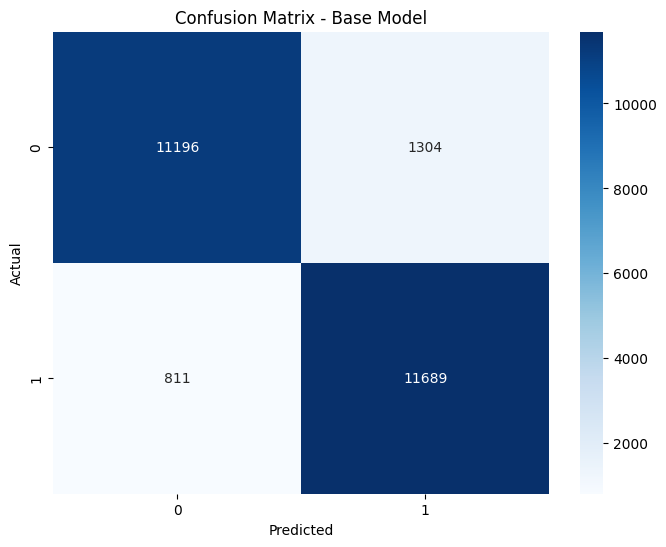

<ipython-input-26-312c1a810b01>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(



Evaluating LoRA Model...


Accuracy: 0.9291
Precision: 0.9291
Recall: 0.9291
F1-Score: 0.9291

Confusion Matrix:
 [[11544   956]
 [  817 11683]]


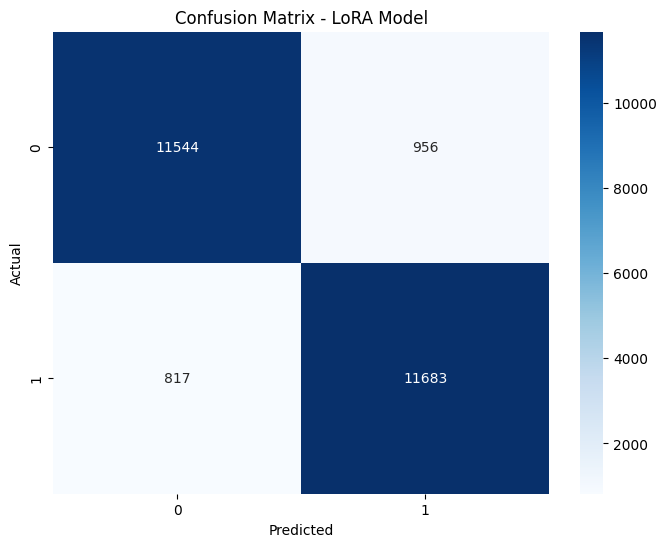


Evaluating Adapter Model...


<ipython-input-26-312c1a810b01>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  adapter_trainer = Trainer(


Accuracy: 0.8454
Precision: 0.8458
Recall: 0.8454
F1-Score: 0.8453

Confusion Matrix:
 [[10356  2144]
 [ 1722 10778]]


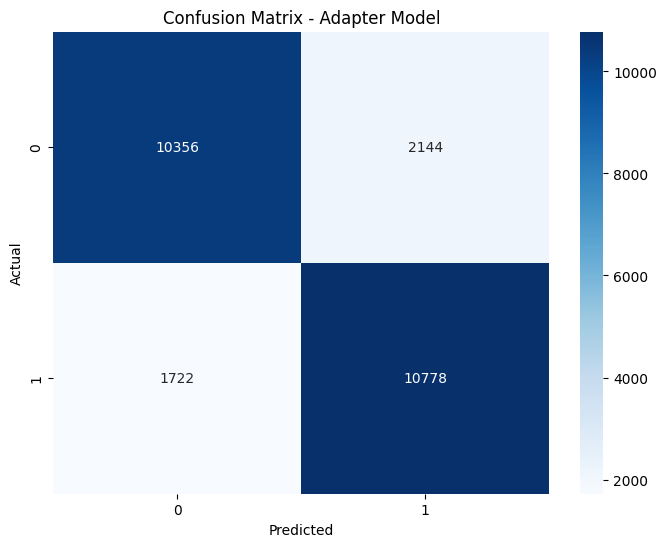


Parameter Size Comparison:
Base Model - Total Params: 355,361,794, Trainable Params: 355,361,794
LoRA Model - Total Params: 357,199,876, Trainable Params: 0
Adapter Model - Total Params: 381,663,234, Trainable Params: 26,303,490

Summary of Results:
Base Model:
  eval_loss: 0.30459874868392944
  accuracy: 0.9154
  precision: 0.9160471670265513
  recall: 0.9154
  f1_score: 0.9153670880886287

LoRA Model:
  eval_loss: 0.18530090153217316
  accuracy: 0.92908
  precision: 0.9291330641915728
  recall: 0.92908
  f1_score: 0.9290778075397113

Adapter Model:
  eval_loss: 0.37639495730400085
  accuracy: 0.84536
  precision: 0.8457540689126928
  recall: 0.84536
  f1_score: 0.8453159251859533



In [41]:
training_args_list = [base_training_args, lora_training_args, adapter_training_args]

# Calculating metrics here for overall comparison
metrics = compare_models(base_model, lora_model, adapter_model, training_args_list, test_dataset, tokenizer=tokenizer)

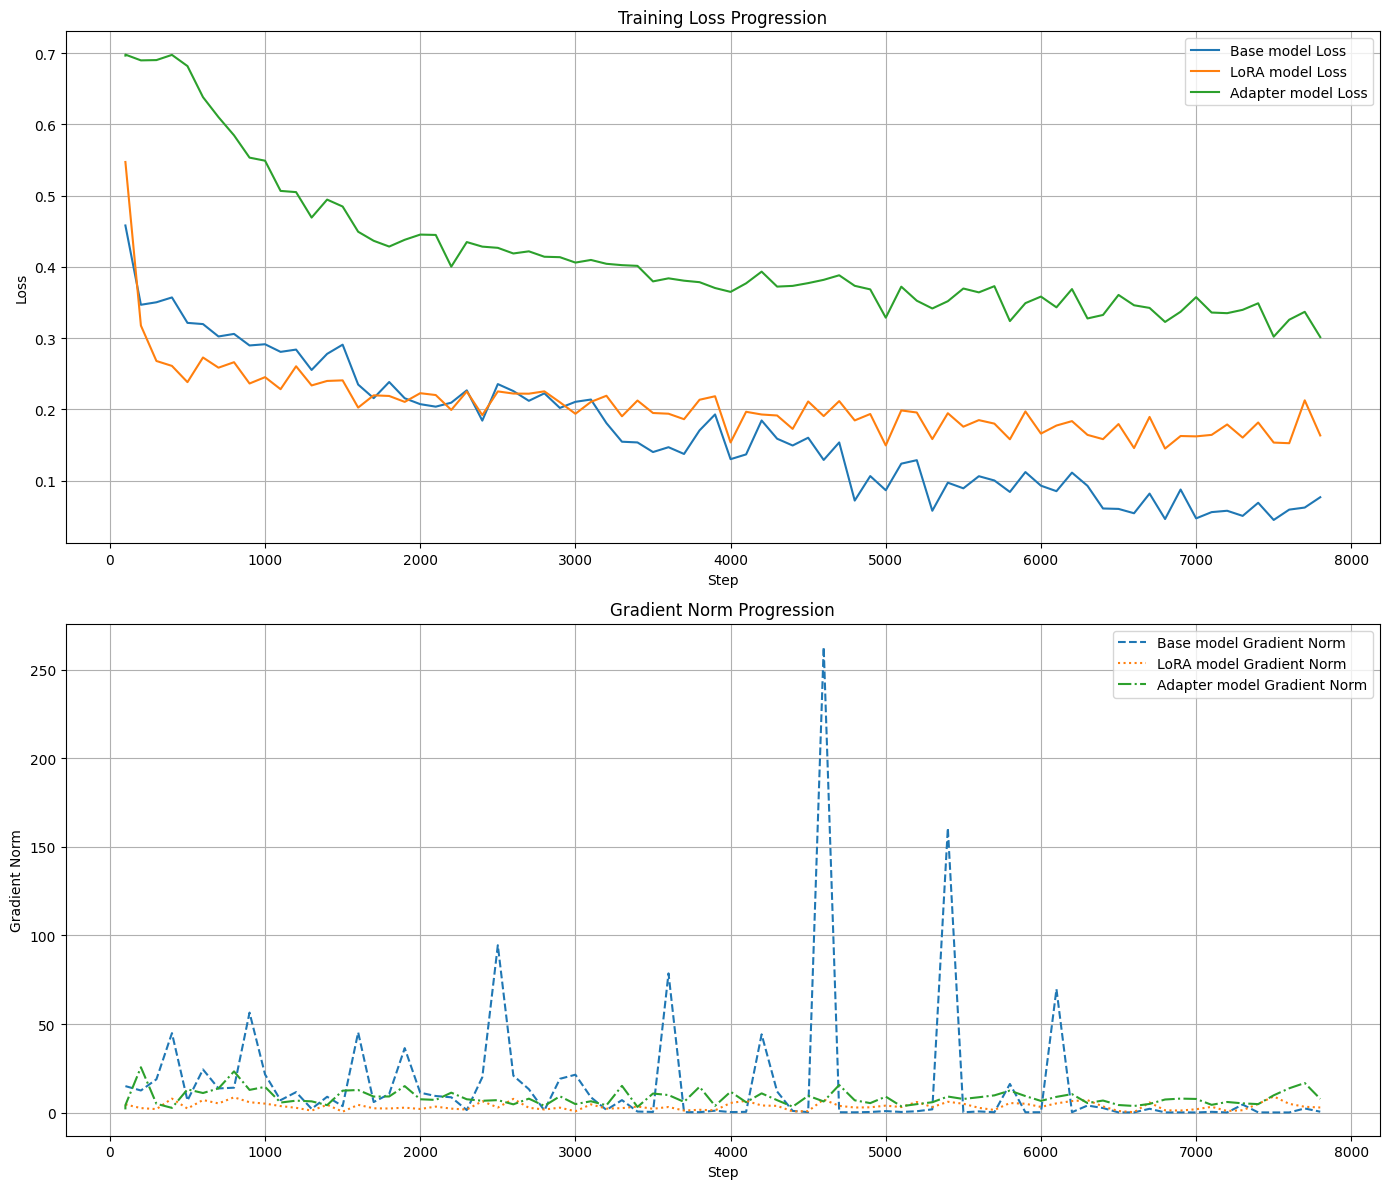

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV logs for all three models
log_model_1 = pd.read_csv('./logs/training_log_base.csv')
log_model_2 = pd.read_csv('./logs/training_log_lora.csv')
log_model_3 = pd.read_csv('./logs/training_log_adapter.csv')

# Plot training loss and gradient norm for all models
plt.figure(figsize=(14, 12))

# Training Loss Plot
plt.subplot(2, 1, 1)
plt.plot(log_model_1['step'], log_model_1['loss'], label="Base model Loss")
plt.plot(log_model_2['step'], log_model_2['loss'], label="LoRA model Loss")
plt.plot(log_model_3['step'], log_model_3['loss'], label="Adapter model Loss")
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Progression')
plt.grid()
plt.legend()

# Gradient Norm Plot
plt.subplot(2, 1, 2)
plt.plot(log_model_1['step'], log_model_1['gradient_norm'], label="Base model Gradient Norm", linestyle='dashed')
plt.plot(log_model_2['step'], log_model_2['gradient_norm'], label="LoRA model Gradient Norm", linestyle='dotted')
plt.plot(log_model_3['step'], log_model_3['gradient_norm'], label="Adapter model Gradient Norm", linestyle='dashdot')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Progression')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [67]:
tokenized_test_dataset = test_dataset.remove_columns(["text"])  # Remove raw text column if present
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


In [79]:
from transformers import DataCollatorWithPadding
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

dataloader = DataLoader(
    tokenized_test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator,
)

def get_predictions(model, dataloader, name, device="cuda"):
    model.eval()
    true_labels, predicted_labels, texts = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            inputs = {key: batch[key].to(device) for key in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(**inputs)
            if name=="adapter_model":
              preds = torch.argmax(outputs, dim=1).cpu().tolist()
            else:
              preds = torch.argmax(outputs.logits, dim=1).cpu().tolist()

            # Decode and collect
            true_labels.extend(labels.cpu().tolist())
            predicted_labels.extend(preds)
            texts.extend(
                tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)
            )

    return texts, true_labels, predicted_labels




def log_errors(texts, true_labels, predicted_labels, output_file="errors.csv"):
    """
    Log mismatched predictions into a CSV file.
    """
    errors = []
    for text, true, pred in zip(texts, true_labels, predicted_labels):
        if true != pred:
            errors.append({"text": text, "true_label": true, "predicted_label": pred})

    df = pd.DataFrame(errors)
    df.to_csv(output_file, index=False)
    print(f"Errors logged in {output_file}")


# Generate predictions
texts, true_labels, predicted_labels = get_predictions(base_model, dataloader, device=device, name="base_model")

# Log errors
log_errors(texts, true_labels, predicted_labels, output_file="base_model_errors.csv")


# For Lora:
# Generate predictions
texts, true_labels, predicted_labels = get_predictions(lora_model, dataloader, device=device, name='lora_model')

# Log errors
log_errors(texts, true_labels, predicted_labels, output_file="lora_model_errors.csv")

# For Adapter
# Generate predictions
texts, true_labels, predicted_labels = get_predictions(adapter_model, dataloader, device=device, name= 'adapter_model')

# Log errors
log_errors(texts, true_labels, predicted_labels, output_file="adapter_model_errors.csv")




Predicting: 100%|██████████| 1563/1563 [02:47<00:00,  9.31it/s]


Errors logged in base_model_errors.csv


Predicting: 100%|██████████| 1563/1563 [02:51<00:00,  9.10it/s]


Errors logged in lora_model_errors.csv


Predicting: 100%|██████████| 1563/1563 [02:52<00:00,  9.08it/s]


Errors logged in adapter_model_errors.csv


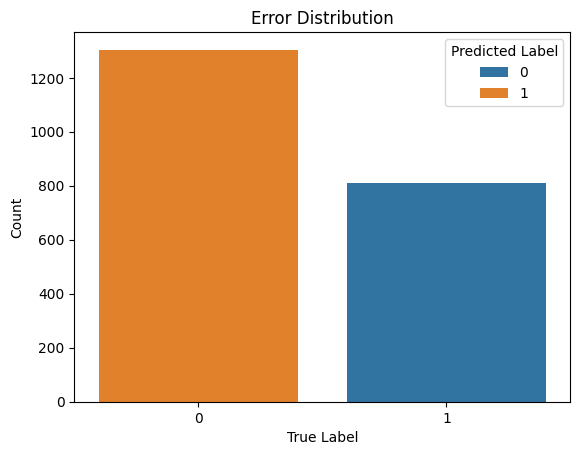

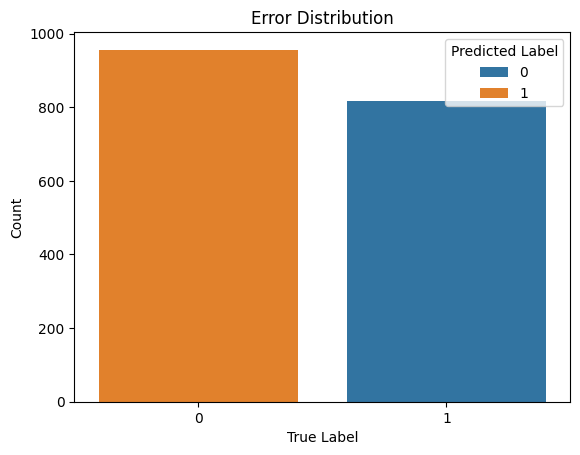

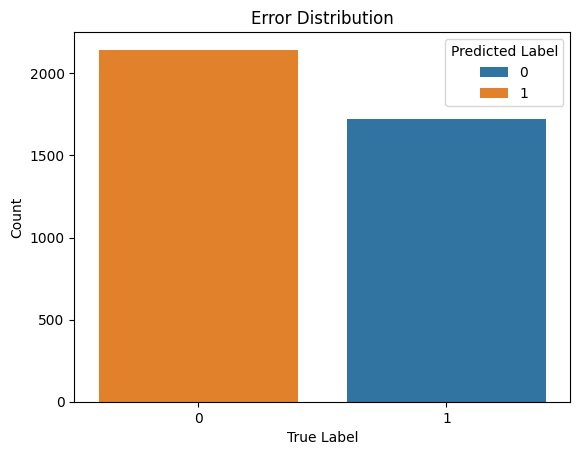

In [80]:
import seaborn as sns

def plot_error_distribution(errors_file="errors.csv"):
    """
    Visualize the distribution of errors.
    """
    df = pd.read_csv(errors_file)
    sns.countplot(x="true_label", hue="predicted_label", data=df)
    plt.title("Error Distribution")
    plt.xlabel("True Label")
    plt.ylabel("Count")
    plt.legend(title="Predicted Label")
    plt.show()

# Plot the distribution
plot_error_distribution("base_model_errors.csv")
plot_error_distribution("lora_model_errors.csv")
plot_error_distribution("adapter_model_errors.csv")
